<a href="https://colab.research.google.com/github/valerio-unifei/UNIFEI-IA-Aulas/blob/main/Otimiza%C3%A7%C3%A3o_Evolutiva_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização Evolutiva

https://github.com/anyoptimization/pymoo

In [1]:
!pip install -U pymoo

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
     |████████████████████████████████| 239 kB 67.3 MB/s 


## Executando Problema Teste

* Problema = zdt1
* Algoritmo de otimização = NSGA2
* População = 100
* Gerações = 200

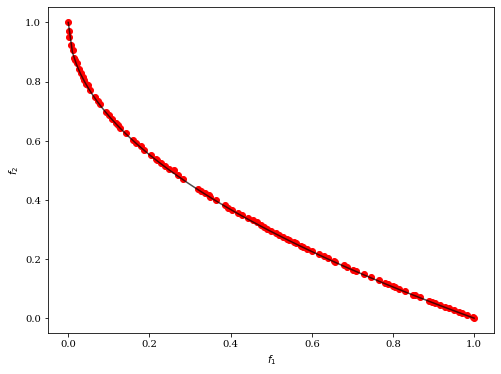

In [5]:
from pymoo import algorithms
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# https://pymoo.org/problems/test_problems.html
problem = get_problem("zdt1")

# https://pymoo.org/algorithms/list.html
algorithm = algorithms.moo.nsga2.NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=42,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
_ = plot.show()

## Customizando Problema para Solucionar

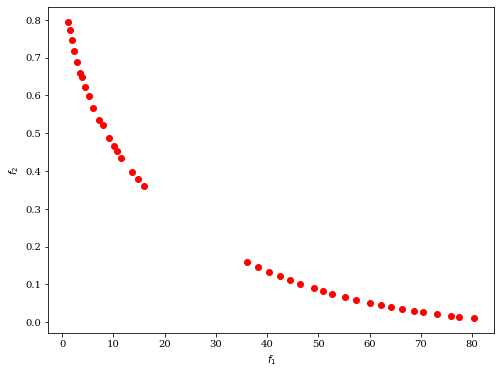

In [11]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=False,
               verbose=False)

plot = Scatter()
plot.add(res.F, color="red")
_ = plot.show()

# Otimização Evolutiva em Deep Learning

https://pygad.readthedocs.io/en/latest/